# Chapter 11: Machine Learning

**ML model** : A specification of a mathematical *(or probabilistic)* relationship that exists between different variables.

**Machine Learning** : Refers to creating and using `models` that are *learned from data*.

### Types of models:
-----
1. *Supervised*: labels exist.
2. *Unsupervised*: labels doesn't exist.
3. *Semi-supervised*: some labels exist.
4. *Online*: models needs to continuously adjust to newly arriving data.
5. *Reinforcement*: Labels exist as `reward` or `punishment` , in a collective sense.

### Overfitting and underfitting
-------
**Overfitting** : Producing a model that performs well on training-data but generalises poorly to any new data.
- May be learning noise in the data.
- Learnt to identify specific inputs rather than actual predictive factors for the desired output/labels.


**Underfitting** : Producing a model that underperforms on both training-data and test-data *(or validation dataset).


> One of the approaches to avoid these issues is to use different data for training and testing. *(Proper splitting before training)*

In [1]:
# example-1

import random
from typing import TypeVar, List, Tuple

X = TypeVar('X') # generic type to represent a data point.


## although scikit learn provides a class model_selection 
## which has a train_test_split which covers everything required to split the data

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Split data into fractions [prob, 1-prob]"""
    data = data[:] # shallow copy
    random.shuffle(data) # shuffle modifies the list
    cut = int(len(data)*prob) # prob to find the cut-off
    return data[:cut], data[cut:]

In [2]:
# temp
data = [n for n in range(1000)]

train, test = split_data(data, 0.75) # 3/4 training, 1/4 test

In [3]:
# checking the split proportion

assert (len(train)) == 750
assert (len(test)) == 250

In [4]:
# original data integrity

assert sorted(train+test)==data

*Now creating the same function with the target variable also from scratch*

In [5]:
Y = TypeVar('Y') # generic type to represent output variables

def train_test_split(xs: List[X], ys: List[Y], test_pct: float) -> Tuple[List[X], List[X], List[Y], List[Y]]:

    # generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1-test_pct)

    return([xs[i] for i in train_idxs], # x_train
           [xs[i] for i in test_idxs],  # x_test
           [ys[i] for i in train_idxs], # y_train
           [ys[i] for i in test_idxs])  # y_test

In [6]:
xs = [x for x in range(1000)] # xs are 1...1000
ys = [2 * x for x in xs] # each y_i is twice x_i

x_train, x_test, y_train, y_test = train_test_split(xs, ys, 0.25)

In [7]:
# checking proportions

assert len(x_train) == len(y_train) == 750
assert len(x_test) == len(y_test) == 250

In [8]:
# whether data points are paired correctly

assert all(y == 2 * x for x,y in zip(x_train, y_train))
assert all(y == 2 * x for x,y in zip(x_test, y_test))

------

> Now for the purpose of properly performing the split & displaying a fit. I am generating another data which is slightly more complicated than the one shown in the book.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

%matplotlib inline

In [10]:
# generating data

np.random.seed(42)
xs = np.linspace(0, 10, 1000)
ys = xs**3 - 10*xs**2 + 30*xs + np.random.normal(0, 100, size=xs.shape)

In [11]:
# using the fn we wrote earlier (as per the book)
x_train, x_test, y_train, y_test = train_test_split(list(xs), list(ys), 0.25)

In [12]:
# Ground truth function, mainly for visualisation
x_plot = np.linspace(min(xs), max(xs), 500).reshape(-1, 1)

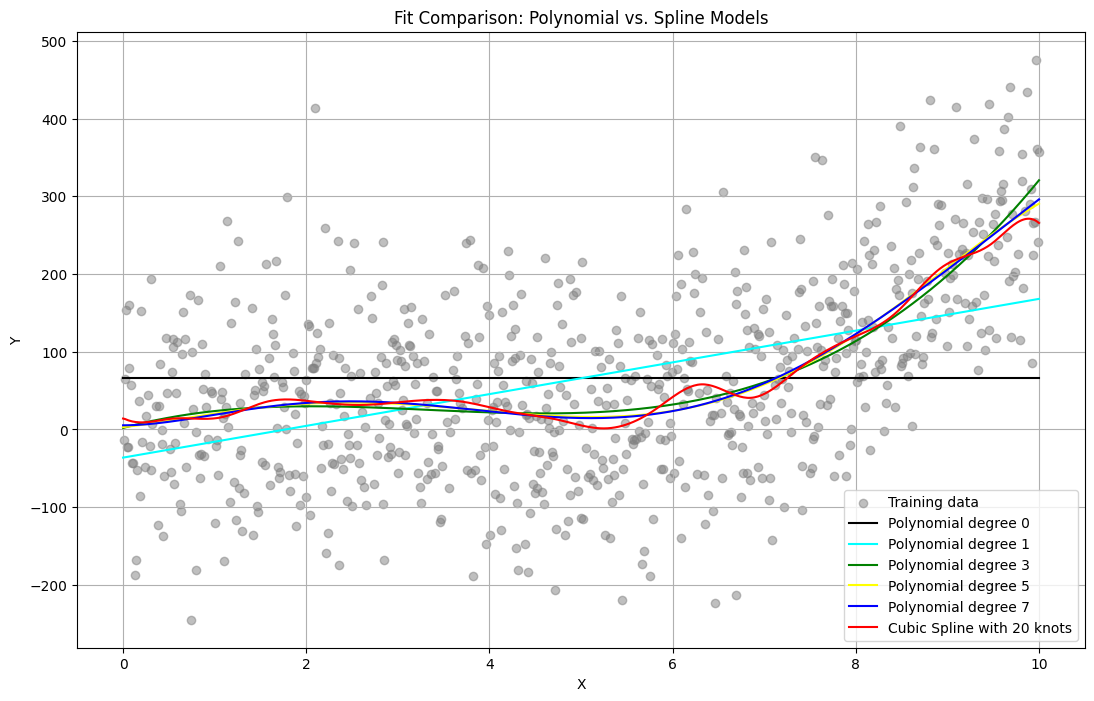

In [13]:
plt.figure(figsize=(13, 8))
plt.scatter(x_train, y_train, color='gray', alpha=0.5, label='Training data')

# Polynomial models
colors = ['black','cyan', 'green', 'yellow', 'blue']
degrees = [0, 1, 3, 5, 7]
for color, degree in zip(colors, degrees):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(np.array(x_train).reshape(-1, 1), y_train)
    y_plot = model.predict(x_plot)
    plt.plot(x_plot, y_plot, color=color, label=f'Polynomial degree {degree}')

# Spline model
spline = make_pipeline(SplineTransformer(n_knots=20, degree=3), Ridge())
spline.fit(np.array(x_train).reshape(-1, 1), y_train)
y_spline = spline.predict(x_plot)
plt.plot(x_plot, y_spline, color='red', label='Cubic Spline with 20 knots')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fit Comparison: Polynomial vs. Spline Models')
plt.legend()
plt.grid(True)
plt.show()

--------

### Correctness

*True positive*: Answer is 1 and our prediction is 1 too.
*False positive*: Answer is 0 and our prediction is 1.
*True negative*: Answer is 0 and our prediction is 0 too.
*False negative*: Answer is 1 and our prediction is 0.

|                 | **Prediction: 1** | **Prediction: 0** |
|-----------------|-------------------|-------------------|
| **Actual: 1**   | True Positive     | False Negative    |
| **Actual: 0**   | False Positive    | True Negative     |


```
The book took a different test to calculate statistic, I am taking a different one to understand and explain too.

A common myth now a days is:
```
**High glucose levels indicate diabetes**    
*Confusion matrix is:*
|                  | **Diabetes** | **No Diabetes** | **Total** |
|------------------|--------------|-----------------|-----------|
| **High Glucose** | 85           | 4915            | 5000      |
| **Normal Glucose** | 13915      | 981085          | 995000    |
| **Total**         | 14000        | 986000          | 1000000   |


In [14]:
def accuracy(tp: int, fp: int, fn: int, tn: int) -> float:
    correct = tp+tn
    total = tp+fp+fn+tn

    return correct/total

In [15]:
assert accuracy(85, 4915, 13915, 981085) == 0.98117

very high accuracy but doesn't show the reality because of *imbalance in the data*.

> let's focus on better success metrics like *precision* & *recall*.

**Precision**: how accurate the *positive* predictions are.

**Recall**: what fraction of the *positives* our model identified.

In [16]:
def precision(tp: int, fp: int, fn: int, tn: int) ->  float:
    return tp / (tp+fp)

In [17]:
def recall(tp: int, fp: int, fn: int, tn: int) -> float:
    return tp / (tp+fn)

In [18]:
assert precision(85, 4915, 13915, 981085) == 0.017
assert round(recall(85, 4915, 13915, 981085), 4) == 0.0061

Finally, we learnt from our success metrics that our model is bad.

> Precison & recall can be combined into F1 score.

In [19]:
def f1_score(tp: int, fp: int, fn: int, tn: int) ->  float:
    p = precision(tp, fp, fn, tn)
    r = recall(tp, fp, fn, tn)

    return 2 * p * r / (p+r)

> Technically, this is the `harmonic mean` of precision and recall and lies b/w them.

*Choice of a model in such scenarios involves a tradeoff b/w precision and recall.*
- A model that predicts `yes` when it's even a little bit confident will probably have a high `recall` but low `precision`.
- A model that predicts `yes` when it's extremely confident will probably have a low `recall` and a high `precision`.


*In other words, it can be thought of in terms of `False positives` & `False negatives`*:
- Too many `yes`: lot of `False positives`.
- Too many `no`: lot of `False negatives`.

------

### The Bias-Variance tradeoff

- `High bias` & `Low variance`: *Underfitting*.
- `Low bias` & `High variance`: *Overfitting*.


*Model has `high bias`, performs poorly on the training data also.*
 > Add more features/dimensions.

*Model has `high variance`, performs poorly on the test data mainly.*
 > Remove features/dimensions.


***Holding model complexity constant, the more data you have, the harder it is to overfit.***

***Holding model complexity constant, the more features there is, easier to control or minimise bias.***

-------------

---------

### Reference: 
1. https://github.com/scikit-learn/scikit-learn/blob/6e9039160/sklearn/model_selection/_split.py#L2686
2. https://scikit-learn.org/1.5/auto_examples/linear_model/plot_polynomial_interpolation.html

---------

# Script Complete